# 量子化学計算について
量子コンピュータは量子系自体のシミュレーションへの利用が期待される  
- 巨大な系の基底状態
- 分子集団のダイナミクス
- タンパク質など複雑な分子のふるまい

これらは古典コンピュータによる計算や実験で特定するのは困難  
離散量子計算ではいくつかの実装により線形スケール時間で計算可能。  
連続量でもHamiltonian Simulationの効率的な実装が見つかっている。  
Bose-Hubbard Hamiltonians

# 化学計算について

今の所、量子コンピュータで古典コンピュータを超えることはできていない。  
ハードウェア的なブレークスルーが必要  
"fault-tolerance"  
最も研究されている誤り訂正符号:surface code  
...物理的な error rate < 1%が必要  
ただし、これだと論理qubit 1つにつき$10^3 to 10^4$の物理qubitが必要

今はNISQである程度どうにかならないか考える時代

### low lying energy levels について  
$$
\frac{P^2}{2m} << \omega
$$
P:total momentum  
m:mass of the electron  
$\omega$:frequency of lattice oscillation  
cf) Debye momentum, Fermi momentum  
これが意味するところは、電子のもつ運動量が小さく、伝導帯にいない  
...基底状態に近い。誘電体と言っても良い?

### 化学系の量子シミュレーションについて
問題は2つに大別される  
"static" or "dynamics"

"dynamics"  
- Trotterization:Hamiltonianを粒子のsmall subsetによるlocal Hamiltonianの和として考える。  
すると、系全体のHamiltonianによる時間発展をlocal Hamiltonianを順次作用させることで表せる。
- variational approach:Trotterizationよりgate数を減らせるが特定の初期状態を要する。

化学的な問題をどう量子コンピュータに落とし込むか  
- grid based method : 上記のdynamicsを落とし込める  
- finite basis set : dynamicsは扱えない, 古典的な方法と組み合わせる必要がある

"static"  
対象となる系の波動関数をqubitの波動関数へマッピングする  
すると、欲しい物理量の期待値が計算できる！  
量子系のエネルギーを求めるのに位相推定アルゴリズムが使える

### 古典化学計算について
- Hartree Fock  
 波動関数のエネルギーが最小になるよう、スピン-軌道の空間形状を最適化する  
 電子間のクーロン力を無視する;独立した各電子が平均電場中を飛ぶ  
 相互作用を無視しているので、強く結びついた分子を正確に計算できない
 
- Multiconfigurational self-consistent field  
 複数のSlater determinantが等しく重要な状態では、static correlationが支配的  
 MCSCFは波動関数を複数のSlater determinantsと考える  
 分子軌道とdeterminantsの振幅を同時に最適化する
 
- Configuration interaction  
 Dynamic correlationは効率的, Static correlationは非効率  
 少数の電子が励起されてる場合に限る  
 欠点:slow convergence, not size extensive
- Coupled cluster

### Chemical basis setsについて
- Slater-type orbitals  
 球面調和関数ベース、実質ラゲール多項式  
 第二量子化されたハミルトニアンの計算における積分評価が難しい
- Gaussian-type orbitals  
 3次元調和振動子によるシュレーディンガー方程式ベース、ガウシアン形状
 原子の電荷分布をあまりうまく近似しないが、積分評価が簡単
 
 
- Slater Type Orbital-n Gaussian  
 n個のGTOsでSTOを近似した  
 minimal basis state, HF stateを記述できるだけの軌道しか持たない  
 精度は出せないので、定性的な説明のみ  
 HF計算であっても真のHF energy は出せず、近似するのみ
- Split valance basis sets  
 STO-nG同様minimal orbitalsしか持たないが、より精度良く近似できる  
 価電子軌道を表現するための動径方向の自由度が大きいため  
 

# Bose-Hubbard Hamiltonian

$$
\begin{align}
H &= J \sum_i \sum_j A_{ij}\hat{a_i}^\dagger \hat{a_j} + \frac{1}{2}U \sum_i \hat{n_i} (\hat{n_i}-1)\\
\end{align}
$$

J : hopping term (the mobility of bosons in the lattice)  
U : on-site interaction potential  
    onsite = 波動関数が、原子軌道同士の線形結合  
A : bosons in the latticeの配置を表す隣接行列

このHamiltonianで時間発展を考えると
$$
e^{-iHt} = \exp [\{-iJ(\hat{a_1}^\dagger \hat{a_2}+\hat{a_2}^\dagger \hat{a_1}) - i\frac{U}{2}(\hat{n_1}^2 - \hat{n_1}+\hat{n_2}^2 - \hat{n_2}) \}\ t]
$$

操作を時間軸方向にkで分割する (メッシュを切る感じ)
$$
\begin{align}
e^{-iHt} &= (e^{-i\frac{Ht}{k}})^k\\
&= [\exp \{-i\frac{Jt}{k}(\hat{a_1}^\dagger \hat{a_2}+\hat{a_2}^\dagger \hat{a_1}) + \frac{Ut}{2k}(\hat{n_1}^2 - \hat{n_1}+\hat{n_2}^2 - \hat{n_2}) \}]^k
\end{align}
$$

# とりあえず実装

In [4]:
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt
%matplotlib inline

eng, q = sf.Engine(2)
J=1
U=1.5
k=20
t=1.086
theta = -J*t/k
r = -U*t/(2*k)
with eng:
    # prepare the initial state
    Fock(2) | q[0]


    for i in range(k):
        BSgate(theta, pi/2) | (q[0], q[1])
        Kgate(r)  | q[0]
        Rgate(-r) | q[0]
        Kgate(r)  | q[1]
        Rgate(-r) | q[1]

state = eng.run('fock', cutoff_dim=10)

print("[2,0] = ",state.fock_prob([2,0]))
print("[1,1] = ",state.fock_prob([1,1])) 
print("[0,2] = ",state.fock_prob([0,2]))

#print("[3,0] = ",state.fock_prob([3,0]))
#print("[2,1] = ",state.fock_prob([2,1])) 
#print("[1,2] = ",state.fock_prob([1,2]))
#print("[0,3] = ",state.fock_prob([0,3]))

[2,0] =  0.24194587742325968
[1,1] =  0.2356528768567246
[0,2] =  0.5224012457200199


In [5]:
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt
%matplotlib inline

J=1
U=1.5
k=40
t_step=0.1
iteNum = 100

A = []
B = []
C = []

for ii in range(iteNum):
    eng, q = sf.Engine(2)
    t = t_step * ii
    theta = -J*t/k
    r = -U*t/(2*k)
    with eng:
        # prepare the initial state
        Fock(2) | q[0]

        for i in range(k):
            BSgate(theta, pi/2) | (q[0], q[1])
            Kgate(r)  | q[0]
            Rgate(-r) | q[0]
            Kgate(r)  | q[1]
            Rgate(-r) | q[1]

    state = eng.run('fock', cutoff_dim=10)

    A.append(state.fock_prob([2,0]))
    B.append(state.fock_prob([1,1])) 
    C.append(state.fock_prob([0,2]))

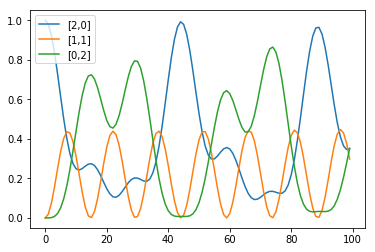

In [9]:
plt.plot(A,label="[2,0]")
plt.plot(B,label="[1,1]")
plt.plot(C,label="[0,2]")
plt.legend()

In [48]:
print(A[-1],B[-1],C[-1])

0.05491717280244177 0.000783983107992385 0.1590482290708527
